# Merton asset/vol Estimation

Hongfei Ge

In [539]:
# import modules
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
from scipy.stats import norm

## 1. Iteration looping

### 1.1 data preparation

In [482]:
# load data
data = pd.read_excel('./Merton asset estimation exercise.xlsx')
sp500 = pd.read_csv('./SPY.csv')[['Date','Adj Close']]
sp500['Date'] = sp500['Date'].apply(lambda x: pd.Timestamp(x))
data = pd.merge(data,sp500[['Date','Adj Close']],left_on='date',right_on='Date',how='left')
data = data.drop('Date',axis=1).dropna()
data = data.set_index('date')
data.columns = ['mktcap', 'debt', 'rf', 'sp_idx']
data.head()

,mktcap,debt,rf,sp_idx
date,,,,
2000-08-31,62715.57,34797,0.059966,102.973351
2000-09-01,63038.83,34797,0.060436,103.079002
2000-09-05,63546.82,34797,0.059966,102.255135
2000-09-06,62346.11,34797,0.060060,101.093460
2000-09-07,61330.10,34797,0.060342,101.959526


### 1.2 Estimate Merton daily asset value

Assumptions:
- all are in one year horizon or annual rate

1)Using the past six months history of daily equity, debt, and riskfree rate, estimate daily series of Merton asset values from Mar 1, 2001 to the end date of the dataset. Note assume all are one year horizon or annual rate.

2)Estimate asset vol from Mar 1, 2001 to the end date of the dataset 

In [508]:
# estimate the initizlised asset value
data['Asset_k'] = data['mktcap'] + data['debt']
data['Asset_k1'] = data['mktcap'] + data['debt'] +np.random.rand(len(data))
data.head()

,mktcap,debt,rf,sp_idx,Asset_k,Asset_k1,Asset_bs,vol,drift_capm,drift_mean
date,,,,,,,,,,
2000-08-31,62715.57,34797,0.059966,102.973351,97512.57,97512.754487,NaN,NaN,NaN,NaN
2000-09-01,63038.83,34797,0.060436,103.079002,97835.83,97836.467628,NaN,NaN,NaN,NaN
2000-09-05,63546.82,34797,0.059966,102.255135,98343.82,98343.968670,NaN,NaN,NaN,NaN
2000-09-06,62346.11,34797,0.060060,101.093460,97143.11,97143.892655,NaN,NaN,NaN,NaN
2000-09-07,61330.10,34797,0.060342,101.959526,96127.10,96127.372403,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='date'>

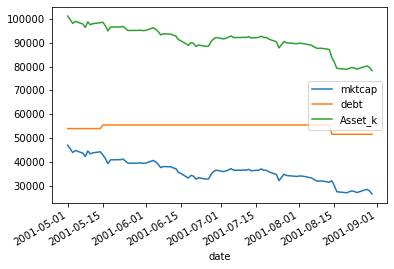

In [509]:
data.loc[pd.Timestamp('2001-05-01'):][['mktcap','debt','Asset_k']].plot()

In [510]:
# define reranged BS model to give Asset value
normal = lambda x: 0.5 * (1 + math.erf(x / math.sqrt(2)))
def Reranged_BS(S, K, sig, t, r, d, eq):
    d1 = (math.log(S / K) + (r - d + sig**2 / 2) * t) / (sig * math.sqrt(t))
    d2 = d1 - sig * math.sqrt(t)
    # call_price = S * math.exp(-d * t) * normasset_iterative_solveral(d1) - \
    #    K * math.exp(-r * t) * normal(d2)
    # put_price = K*math.exp(-r*t) * normal(-d2) - S*math.exp(-d*t)*normal(-d1)
    E = eq
    Reranged_BS.A = (E + K * np.exp(-r * t) * normal(d2)) / normal(d1)
    Reranged_BS.d2 = d2
    Reranged_BS.vol = sig
    return Reranged_BS

In [511]:
# iteration method
def asset_iterative_solver(window):
    data_ = data.loc[window.index]
    it_count = 0
    while np.std(data_['Asset_k']-data_['Asset_k1'])>1e-10:
        data_['Asset_k'] = data_['Asset_k1'] 
        vol = (np.log(data_['Asset_k']/data_['Asset_k'].shift())).std()*np.sqrt(250)
        # print(vol)
        def f(x):
            S, K, sig, t, r, d, eq = x[4], x[1], vol, 1, np.log(1+x[2]), 0, x[0]
            res = Reranged_BS(S, K, sig, t, r, d, eq)
            return res.A
        data_['Asset_k1'] = data_.apply(f,axis=1)
        it_count += 1
        if it_count > 1000:
            print('max iteration reached!')
            break
    A = data_['Asset_k'][-1]
    return A

def vol_iterative_solver(window):
    data_ = data.loc[window.index]
    it_count = 0
    while np.std(data_['Asset_k']-data_['Asset_k1'])>1e-10:
        data_['Asset_k'] = data_['Asset_k1'] 
        vol = (np.log(data_['Asset_k']/data_['Asset_k'].shift())).std()*np.sqrt(250)
        # print(vol)
        def f(x):
            S, K, sig, t, r, d, eq = x[4], x[1], vol, 1, x[2], 0, x[0]
            res = Reranged_BS(S, K, sig, t, r, d, eq)
            return res.A
        data_['Asset_k1'] = data_.apply(f,axis=1)
        it_count += 1
        if it_count > 1000:
            print('max iteration reached!')
            break
    A = data_['Asset_k'][-1]
    return vol

In [512]:
# might take a while
asset_bs = data['rf'].rolling(60).apply(asset_iterative_solver)
vol =  data['rf'].rolling(60).apply(vol_iterative_solver)
data['Asset_bs'] = asset_bs
data['vol'] = vol
res = data.loc[pd.Timestamp('2001-05-01'):]
res.head()

,mktcap,debt,rf,sp_idx,Asset_k,Asset_k1,Asset_bs,vol,drift_capm,drift_mean
date,,,,,,,,,,
2001-05-01,47080.00,54033,0.038355,86.588928,101113.00,101113.033523,98699.677485,0.365645,0.047222,0.047222
2001-05-02,45639.19,54033,0.038740,86.432205,99672.19,99672.346487,97195.968507,0.366092,0.047589,0.047589
2001-05-03,44017.29,54033,0.038162,85.334885,98050.29,98051.140133,95538.661404,0.367665,0.047039,0.047039
2001-05-04,44869.71,54033,0.038259,86.786575,98902.71,98902.743665,96411.232090,0.368180,0.047130,0.047130
2001-05-07,43783.41,54033,0.036621,86.036896,97816.41,97816.575003,95362.761683,0.368769,0.045567,0.045567


<AxesSubplot:xlabel='date'>

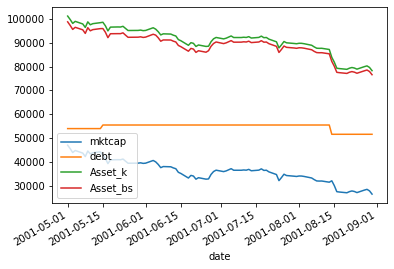

In [513]:
res[['mktcap','debt','Asset_k','Asset_bs']].plot()

<AxesSubplot:xlabel='date'>

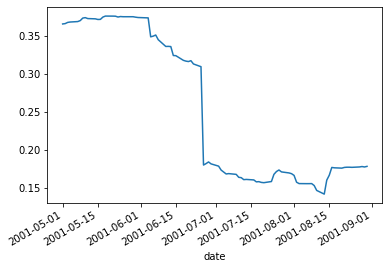

In [514]:
res['vol'].plot()

## 2. Asset Drift

### 2.1 Estimate drift

1)Estimate daily series of the drift, (i.e.) expectation of asset growth by using CAPM 
- Use CAPM and choose SP500 as a proxy for market portfolio (you can get SP500 data from Yahoo Finance or Google Finance)
- Use simple average of asset growth for past 6 months

Note. If CAPM drift / simple average of growth are found to be lower than riskfree rates, you can use drift as riskfree rate + xx% to ensure asset growth rate larger than riskfree rate 

In [515]:
def drift_CAPM_solver(window):
    data_ = data.loc[window.index]
    it_count = 0
    while np.std(data_['Asset_k']-data_['Asset_k1'])>1e-10:
        data_['Asset_k'] = data_['Asset_k1']
        asset_ret = np.log(data_['Asset_k']/data_['Asset_k'].shift())
        vol = asset_ret.std()*np.sqrt(250)
        # print(vol)
        def f(x):
            S, K, sig, t, r, d, eq = x[4], x[1], vol, 1, x[2], 0, x[0]
            res = Reranged_BS(S, K, sig, t, r, d, eq)
            return res.A
        data_['Asset_k1'] = data_.apply(f,axis=1)
        it_count += 1
        if it_count > 1000:
            print('max iteration reached!')
            break
    # CAPM
    A = data_['Asset_k'].values
    rf = data_['rf'].values[1:]/250
    y = (A[1:]/A[:-1]) - 1 - rf
    idx = data_['sp_idx'].values
    x = idx[1:]/idx[:-1] - 1 - rf
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    beta = results.params[1]
    drift = (rf[-1] + beta * np.mean(asset_ret))*250
    # print(beta,drift,rf[-1]*250)
    if drift < rf[-1]*250:
        drift = (rf[-1]*250 + 0.01)
    return np.log(1 + drift)

In [516]:
def drift_mean_solver(window):
    data_ = data.loc[window.index]
    it_count = 0
    while np.std(data_['Asset_k']-data_['Asset_k1'])>1e-10:
        data_['Asset_k'] = data_['Asset_k1']
        asset_ret = np.log(data_['Asset_k']/data_['Asset_k'].shift())
        vol = asset_ret.std()*np.sqrt(250)
        # print(vol)
        def f(x):
            S, K, sig, t, r, d, eq = x[4], x[1], vol, 1, x[2], 0, x[0]
            res = Reranged_BS(S, K, sig, t, r, d, eq)
            return res.A
        data_['Asset_k1'] = data_.apply(f,axis=1)
        it_count += 1
        if it_count > 1000:
            print('max iteration reached!')
            break
    drift = np.mean(asset_ret)*250
    rf = data_['rf'].values[1:]
    if drift < rf[-1]:
        drift = (rf[-1] + 0.01)
    return np.log(1 + drift)

In [517]:
# might take a while
data['drift_capm'] = data['rf'].rolling(60).apply(drift_CAPM_solver)
data['drift_mean'] =  data['rf'].rolling(60).apply(drift_mean_solver)
res = data.loc[pd.Timestamp('2001-05-01'):]
res.head()

,mktcap,debt,rf,sp_idx,Asset_k,Asset_k1,Asset_bs,vol,drift_capm,drift_mean
date,,,,,,,,,,
2001-05-01,47080.00,54033,0.038355,86.588928,101113.00,101113.033523,98699.677485,0.365645,0.047222,0.047222
2001-05-02,45639.19,54033,0.038740,86.432205,99672.19,99672.346487,97195.968507,0.366092,0.047589,0.047589
2001-05-03,44017.29,54033,0.038162,85.334885,98050.29,98051.140133,95538.661404,0.367665,0.047039,0.047039
2001-05-04,44869.71,54033,0.038259,86.786575,98902.71,98902.743665,96411.232090,0.368180,0.047130,0.047130
2001-05-07,43783.41,54033,0.036621,86.036896,97816.41,97816.575003,95362.761683,0.368769,0.045567,0.045567


<AxesSubplot:xlabel='date'>

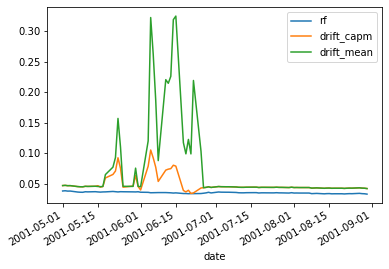

In [518]:
res[['rf','drift_capm','drift_mean']].plot()

### 2.2 DD
2)Calculate DDs using the values from 1) based on each method

In [534]:
def DD(S, K, sig, t, mu, d):
    d1 = (math.log(S / K) + (mu - d + sig**2 / 2) * t) / (sig * math.sqrt(t))
    d2 = d1 - sig * math.sqrt(t)
    return d2

In [536]:
dd_capm = lambda x: DD(S=x[6], K=x[1], sig=x[7], t=1, mu=x[8], d=0)
dd_mean = lambda x: DD(S=x[6], K=x[1], sig=x[7], t=1, mu=x[9], d=0)
dd_rf = lambda x: DD(S=x[6], K=x[1], sig=x[7], t=1, mu=np.log(1+x[2]), d=0)
res['dd_capm'] = res.apply(dd_capm,axis=1)
res['dd_mean'] = res.apply(dd_mean,axis=1)
res['dd_rf'] = res.apply(dd_rf,axis=1)
res.head()

/home/clarence/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/clarence/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/clarence/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,mktcap,debt,rf,sp_idx,Asset_k,Asset_k1,Asset_bs,vol,drift_capm,drift_mean,dd_capm,dd_mean,dd_rf
date,,,,,,,,,,,,,
2001-05-01,47080.00,54033,0.038355,86.588928,101113.00,101113.033523,98699.677485,0.365645,0.047222,0.047222,1.594062,1.594062,1.567850
2001-05-02,45639.19,54033,0.038740,86.432205,99672.19,99672.346487,97195.968507,0.366092,0.047589,0.047589,1.550734,1.550734,1.524563
2001-05-03,44017.29,54033,0.038162,85.334885,98050.29,98051.140133,95538.661404,0.367665,0.047039,0.047039,1.494254,1.494254,1.468181
2001-05-04,44869.71,54033,0.038259,86.786575,98902.71,98902.743665,96411.232090,0.368180,0.047130,0.047130,1.516595,1.516595,1.490561
2001-05-07,43783.41,54033,0.036621,86.036896,97816.41,97816.575003,95362.761683,0.368769,0.045567,0.045567,1.479692,1.479692,1.453658


### 2.3 PD

3)Calculate default probabilities (you can use inverse of cumulative normal distribution) based on CAPM drift, simple average, and riskfree rate and compare each DP

In [555]:
PD = (-res[['dd_capm','dd_mean','dd_rf']]).applymap(norm.cdf)
PD.columns = ['pd_capm','pd_mean','pd_rf']
PD.head()

,pd_capm,pd_mean,pd_rf
date,,,
2001-05-01,0.055461,0.055461,0.058458
2001-05-02,0.060483,0.060483,0.063684
2001-05-03,0.067555,0.067555,0.071028
2001-05-04,0.064684,0.064684,0.068038
2001-05-07,0.069478,0.069478,0.073021


<AxesSubplot:xlabel='date'>

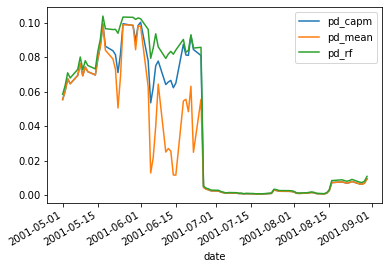

In [556]:
PD.plot()